In [1]:
import numpy as np
import json
from datetime import datetime
from typing import Dict, List, Tuple

from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.quantum_info import (
    DensityMatrix, Statevector, Operator, Choi, SuperOp, Kraus,
    partial_trace, hellinger_fidelity, random_clifford, process_fidelity
)

In [2]:
# --------------------------
# 1) Utility: Kraus channels
# --------------------------

def amplitude_damping_kraus(gamma: float) -> Kraus:
    """Single-qubit amplitude damping channel as Kraus."""
    k0 = np.array([[1, 0], [0, np.sqrt(1 - gamma)]], dtype=complex)
    k1 = np.array([[0, np.sqrt(gamma)], [0, 0]], dtype=complex)
    return Kraus([k0, k1])

def phase_damping_kraus(lam: float) -> Kraus:
    """Single-qubit phase damping (dephasing) as Kraus."""
    k0 = np.sqrt(1 - lam) * np.eye(2, dtype=complex)
    k1 = np.sqrt(lam) * np.array([[1, 0],[0, 0]], dtype=complex)
    k2 = np.sqrt(lam) * np.array([[0, 0],[0, 1]], dtype=complex)
    return Kraus([k0, k1, k2])

def tensor_two_qubit_channel(k1: Kraus, k2: Kraus) -> Kraus:
    """Tensor product channel on 2 qubits: k1 ⊗ k2."""
    mats = []
    for a in k1.data:
        for b in k2.data:
            mats.append(np.kron(a, b))
    return Kraus(mats)

In [3]:
# ---------------------------------------
# 2) Target spec & reference Choi / SuperOp
# ---------------------------------------

def create_target_specification(
    gamma_ad: float = 0.10,
    gamma_ph: float = 0.05,
    n_qubits: int = 2
) -> Dict:
    """
    Build a 2-qubit target channel = (AD on qubit 0) ⊗ (PHASE on qubit 1).
    Returns Kraus, SuperOp, Choi for reference, and simple diagonal H for passivity tests.
    """
    assert n_qubits == 2, "This example targets 2 qubits (easy to generalize)."

    ad = amplitude_damping_kraus(gamma_ad)      # acts on qubit-0
    ph = phase_damping_kraus(gamma_ph)          # acts on qubit-1
    k_2q = tensor_two_qubit_channel(ad, ph)

    superop = SuperOp(k_2q)     # reference superoperator
    choi   = Choi(k_2q)         # reference Choi

    # Diagonal Hamiltonian (computational basis): E(|00>)=0, |01>=1, |10>=1, |11>=2
    H_diag = np.array([0, 1, 1, 2], dtype=float)

    return {
        "n_qubits": 2,
        "kraus_2q": k_2q,
        "superop_ref": superop,
        "choi_ref": choi,
        "H_diag": H_diag,
        "params": {"gamma_ad": gamma_ad, "gamma_ph": gamma_ph}
    }


In [4]:
# ------------------------------------------
# 3) Simulator execution helpers (Aer 2.1.2)
# ------------------------------------------

def run_density_matrix(circ: QuantumCircuit) -> DensityMatrix:
    """Run a circuit on AerSimulator (density_matrix method) and return DensityMatrix."""
    backend = AerSimulator(method="density_matrix")
    tcirc = transpile(circ, backend)
    tcirc.save_density_matrix()
    result = backend.run(tcirc, shots=1).result()
    return DensityMatrix(result.data(tcirc)["density_matrix"])

def run_counts(circuits: List[QuantumCircuit], shots: int = 1000) -> List[Dict[str, int]]:
    """Run measurement circuits (sampling) on qasm AerSimulator and return counts list."""
    backend = AerSimulator()  # default is sampling
    tcircs = transpile(circuits, backend)
    job = backend.run(tcircs, shots=shots)
    res = job.result()
    return [res.get_counts(i) for i in range(len(circuits))]


In [5]:
# ------------------------------------
# 4) Tier A: Ancilla-Assisted "QPT"
# ------------------------------------

def bell_pair_circuit(n_qubits: int) -> QuantumCircuit:
    """Prepare |Phi+>^(n) across (system[i], ancilla[i]) pairs."""
    qc = QuantumCircuit(2 * n_qubits)
    for i in range(n_qubits):
        qc.h(i)
        qc.cx(i, i + n_qubits)
    return qc

def append_two_qubit_kraus(qc: QuantumCircuit, kraus: Kraus, sys_qubits: Tuple[int,int]):
    """Append a 2-qubit Kraus channel instruction to the system qubits."""
    kraus_inst = kraus.to_instruction()  # Kraus -> Instruction (supported by Aer)
    qc.append(kraus_inst, list(sys_qubits))

def run_aaqpt_on_simulator(target: Dict) -> Dict:
    """
    Prepare maximally entangled state |Omega><Omega| on (S,A). Apply channel on S.
    The output density matrix IS the Choi state (up to convention) – retrieve it directly.
    Then compare with reference Choi.
    """
    n = target["n_qubits"]
    k2q = target["kraus_2q"]
    qc = bell_pair_circuit(n_qubits=n)
    # Apply channel to system qubits only: system qubits are [0,1], ancilla [2,3]
    append_two_qubit_kraus(qc, k2q, sys_qubits=(0, 1))

    rho_out = run_density_matrix(qc)
    choi_rec = Choi(partial_trace(rho_out, [2,3]))  # trace out ancilla
    F_proc = process_fidelity(choi_rec, target["choi_ref"])

    return {
        "choi_reconstructed": choi_rec,
        "process_fidelity": F_proc
    }


In [6]:
# ------------------------------------
# 5) Tier B: Randomized Benchmarking
# ------------------------------------

def rb_sequence(n_qubits: int, length: int, seed: int) -> QuantumCircuit:
    """
    Build a simple Clifford RB sequence (no interleaved gate). For simulator only.
    We just build random Cliffords and then append their inverse.
    """
    rng = np.random.default_rng(seed)
    qc = QuantumCircuit(n_qubits, n_qubits)

    clifs = [random_clifford(n_qubits, seed=int(rng.integers(1e9)))]
    for _ in range(1, length):
        clifs.append(random_clifford(n_qubits, seed=int(rng.integers(1e9))))

    # Compose sequence
    for C in clifs:
        qc.append(C.to_instruction(), range(n_qubits))

    # Inverse
    net = clifs[0]
    for C in clifs[1:]:
        net = C.compose(net)
    inv = net.adjoint()
    qc.append(inv.to_instruction(), range(n_qubits))

    qc.measure(range(n_qubits), range(n_qubits))
    return qc

def run_rb_on_simulator(target: Dict, sequence_lengths=None, shots=1024) -> Dict:
    if sequence_lengths is None:
        sequence_lengths = [1, 2, 5, 10, 20]

    n = target["n_qubits"]
    circs = []
    meta = []

    # make a few sequences per length
    for L in sequence_lengths:
        for seed in range(5):
            qc = rb_sequence(n, L, seed)
            circs.append(qc)
            meta.append({"L": L, "seed": seed})

    counts_list = run_counts(circs, shots=shots)
    surv = {L: [] for L in sequence_lengths}
    for c, m in zip(counts_list, meta):
        p0 = c.get("0" * n, 0) / shots
        surv[m["L"]].append(p0)

    avg_surv = [float(np.mean(surv[L])) for L in sequence_lengths]

    def decay_model(m, A, B, p):
        return A * (p ** m) + B

    try:
        popt, _ = curve_fit(decay_model, sequence_lengths, avg_surv, p0=[0.95, 0.05, 0.99])
        A, B, p = popt
        # Standard RB relation
        d = 2 ** n
        avg_gate_fid = (1 + (d - 1) * p) / d
    except Exception:
        avg_gate_fid = float(np.mean(avg_surv))

    return {
        "sequence_lengths": sequence_lengths,
        "avg_survival": avg_surv,
        "average_gate_fidelity": avg_gate_fid
    }

In [7]:
# ------------------------------------
# 6) Tier C: Direct Fidelity Estimation (process)
# ------------------------------------

def sample_pauli_strings(n_qubits: int, k: int) -> List[str]:
    paulis = ['I', 'X', 'Y', 'Z']
    rng = np.random.default_rng(1234)
    out = []
    while len(out) < k:
        s = "".join(rng.choice(paulis, size=n_qubits))
        if s not in out:
            out.append(s)
    return out

def pauli_measure_circuit(pauli_str: str) -> QuantumCircuit:
    """Measure in the Pauli basis on n qubits (no state prep)."""
    n = len(pauli_str)
    qc = QuantumCircuit(n, n)
    # basis change
    for i, p in enumerate(pauli_str):
        if p == 'X':
            qc.h(i)
        elif p == 'Y':
            qc.sdg(i)
            qc.h(i)
        # 'Z' or 'I': measure in Z; for 'I' we'll ignore that bit when computing expectation
    qc.measure(range(n), range(n))
    return qc

def estimate_process_fidelity_dfe(target: Dict, samples: int = 8, shots: int = 2000) -> Dict:
    """
    Very light DFE-style estimator: we sample Pauli strings on the Choi state obtained
    by AAQPT (simulator exact density matrix), compute exact expectations, but also
    show what a sampling workflow would look like.
    """
    # Get exact Choi (from reference channel):
    choi_ref = target["choi_ref"]
    # Also reconstruct via simulator once for fairness
    aaqpt = run_aaqpt_on_simulator(target)
    choi_rec = aaqpt["choi_reconstructed"]

    # Sample a few 2n-qubit Pauli strings
    n = target["n_qubits"] * 2
    paulis = sample_pauli_strings(n, samples)

    # Compute exact expectations (no circuit sampling, since we have density matrices)
    rho_ref = DensityMatrix(choi_ref.data)
    rho_rec = DensityMatrix(choi_rec.data)

    def pauli_op(s: str) -> Operator:
        op = Operator(np.array([[1]], dtype=complex))
        for ch in s:
            if ch == 'I':
                op = op ^ Operator(np.eye(2))
            elif ch == 'X':
                op = op ^ Operator([[0,1],[1,0]])
            elif ch == 'Y':
                op = op ^ Operator([[0,-1j],[1j,0]])
            elif ch == 'Z':
                op = op ^ Operator([[1,0],[0,-1]])
        return op

    ex_ref, ex_rec = [], []
    for s in paulis:
        O = pauli_op(s)
        ex_ref.append(float(np.real(np.trace(rho_ref.data @ O.data))))
        ex_rec.append(float(np.real(np.trace(rho_rec.data @ O.data))))

    # Turn correlation between expectations into a crude fidelity proxy
    num = np.dot(ex_ref, ex_rec)
    den = np.linalg.norm(ex_ref) * np.linalg.norm(ex_rec) + 1e-12
    proxy = float(max(0.0, min(1.0, 0.5 * (num / den + 1.0))))  # rescale cosine to [0,1]

    # Also compute exact process fidelity
    F_proc_exact = process_fidelity(choi_rec, choi_ref)

    return {
        "sampled_paulis": paulis,
        "exp_ref": ex_ref,
        "exp_rec": ex_rec,
        "fidelity_proxy": proxy,
        "process_fidelity_exact": F_proc_exact
    }

In [8]:
# ------------------------------------
# 7) Tier D: Passivity checks (sim)
# ------------------------------------

def apply_channel_on_basis_and_measure(H_diag: np.ndarray, kraus: Kraus, shots: int = 2000) -> Dict:
    """
    Prepare |00>, |01>, |10>, |11>, apply 2-qubit channel (Kraus), measure in Z.
    Also compute ⟨H⟩ before/after from counts as a simple passivity proxy.
    """
    n = 2
    basis_states = ["00", "01", "10", "11"]
    circuits = []
    for s in basis_states:
        qc = QuantumCircuit(n, n)
        for i, b in enumerate(reversed(s)):  # Qiskit's endianness: leftmost is highest index in str
            if b == '1':
                qc.x(i)
        # append channel
        qc.append(kraus.to_instruction(), [0, 1])
        qc.measure(range(n), range(n))
        circuits.append(qc)

    counts_list = run_counts(circuits, shots=shots)
    # Map bitstring to energy using H_diag order |00>,|01>,|10>,|11| (Qiskit's bitstring is little-endian)
    basis = ["00", "01", "10", "11"]
    energy_map = {basis[i][::-1]: H_diag[i] for i in range(4)}  # reverse keys to match Qiskit counts keys

    def exp_H(counts: Dict[str,int]) -> float:
        total = sum(counts.values())
        if total == 0:
            return 0.0
        val = 0.0
        for bitstr, c in counts.items():
            val += energy_map.get(bitstr, 0.0) * (c / total)
        return float(val)

    results = {}
    for s, cnts in zip(basis_states, counts_list):
        # initial energy (pure computational basis state)
        Ei = float(H_diag[basis.index(s)])
        Ef = exp_H(cnts)
        results[s] = {"counts": cnts, "E_initial": Ei, "E_final": Ef}

    return results

In [9]:
# ------------------------------------
# 8) Experiment book, runner, plots
# ------------------------------------

def generate_experiment_book() -> Dict:
    return {
        "metadata": {
            "experiment_id": "device_channel_characterization_qiskit_2_1_2",
            "timestamp": datetime.now().isoformat(),
            "platform": "AerSimulator",
            "n_qubits": 2
        },
        "exec": {
            "shots": 2048
        },
        "tiers": {
            "AAQPT": True,
            "RB": True,
            "DFE": True,
            "PASSIVITY": True
        }
    }

def run_complete_device_characterization() -> Dict:
    print("Quantum Channel Characterization — Qiskit 2.1.2 (Simulator)")
    print("=" * 60)

    target = create_target_specification()
    book = generate_experiment_book()
    shots = book["exec"]["shots"]

    out = {
        "book": book,
        "target_params": target["params"],
        "results": {}
    }

    if book["tiers"]["AAQPT"]:
        print("[Tier A] AAQPT (sim)")
        out["results"]["AAQPT"] = run_aaqpt_on_simulator(target)

    if book["tiers"]["RB"]:
        print("[Tier B] Randomized Benchmarking (sim)")
        out["results"]["RB"] = run_rb_on_simulator(target, shots=shots)

    if book["tiers"]["DFE"]:
        print("[Tier C] Direct Fidelity Estimation (sim)")
        out["results"]["DFE"] = estimate_process_fidelity_dfe(target, samples=8, shots=shots)

    if book["tiers"]["PASSIVITY"]:
        print("[Tier D] Passivity Checks (sim)")
        out["results"]["PASSIVITY"] = apply_channel_on_basis_and_measure(
            target["H_diag"], target["kraus_2q"], shots=shots
        )

    # persist JSON
    with open("device_characterization_results_qiskit212.json", "w") as f:
        json.dump(out, f, indent=2, default=lambda x: x if isinstance(x, (int,float,str,bool)) else None)

    print("\nSaved: device_characterization_results_qiskit212.json")
    return out

def plot_device_results(results: Dict):
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))

    # RB
    if "RB" in results:
        rb = results["RB"]
        axes[0, 0].plot(rb["sequence_lengths"], rb["avg_survival"], "o-")
        axes[0, 0].set_title(f"RB avg gate fidelity ≈ {rb['average_gate_fidelity']:.4f}")
        axes[0, 0].set_xlabel("Sequence Length")
        axes[0, 0].set_ylabel("Survival prob.")
        axes[0, 0].grid(True)

    # Fidelity comparison (AAQPT exact vs DFE proxy)
    vals = {}
    if "AAQPT" in results:
        vals["AAQPT_procF"] = results["AAQPT"]["process_fidelity"]
    if "DFE" in results:
        vals["DFE_proxy"] = results["DFE"]["fidelity_proxy"]
        vals["DFE_exact_procF"] = results["DFE"]["process_fidelity_exact"]
    if vals:
        axes[0, 1].bar(list(vals.keys()), list(vals.values()))
        axes[0, 1].set_title("Fidelity metrics")
        axes[0, 1].set_ylim(0, 1.05)
        axes[0, 1].grid(True)

    # AAQPT: nothing to plot beyond metrics (skip)

    # Passivity energies
    if "PASSIVITY" in results:
        pass_res = results["PASSIVITY"]
        states = list(pass_res.keys())
        E_i = [pass_res[s]["E_initial"] for s in states]
        E_f = [pass_res[s]["E_final"] for s in states]
        x = np.arange(len(states))
        axes[1, 1].bar(x - 0.2, E_i, width=0.4, label="Initial")
        axes[1, 1].bar(x + 0.2, E_f, width=0.4, label="Final")
        axes[1, 1].set_xticks(x, states)
        axes[1, 1].set_title("Passivity proxy: ⟨H⟩ before/after")
        axes[1, 1].legend()
        axes[1, 1].grid(True)

    plt.tight_layout()
    plt.savefig("device_characterization_results_qiskit212.png", dpi=300, bbox_inches="tight")
    plt.show()

Input channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.949375 -0.949375 -0.924375 -0.924375]


Quantum Channel Characterization — Qiskit 2.1.2 (Simulator)
[Tier A] AAQPT (sim)
[Tier B] Randomized Benchmarking (sim)


Input channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.949375 -0.949375 -0.924375 -0.924375]
Input channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.949375 -0.949375 -0.924375 -0.924375]


[Tier C] Direct Fidelity Estimation (sim)
[Tier D] Passivity Checks (sim)

Saved: device_characterization_results_qiskit212.json


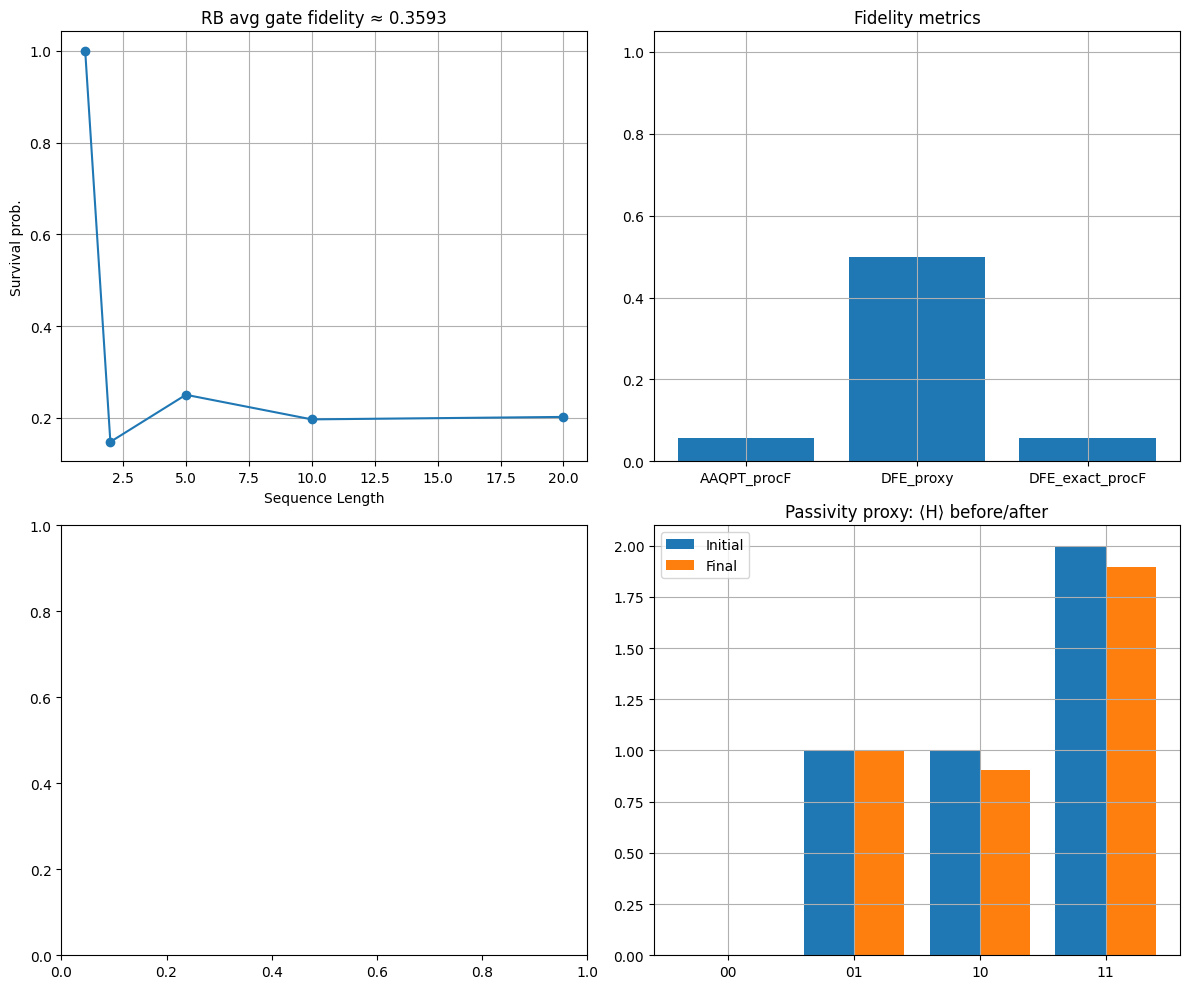

In [10]:
results = run_complete_device_characterization()
plot_device_results(results["results"])